In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout

In [17]:
fmnist_test = pd.read_csv("D:\\ds\\fmnist_test.csv")
fmnist_train = pd.read_csv("D:\\ds\\fmnist_train.csv")
sample_submission = pd.read_csv("D:\\ds\\sample_submission.csv")

In [19]:
fmnist_train.isna().sum().sort_values(ascending=False)

pixel393    1
pixel495    1
pixel497    1
pixel498    1
pixel499    1
           ..
pixel242    0
pixel243    0
pixel244    0
pixel245    0
Id          0
Length: 786, dtype: int64

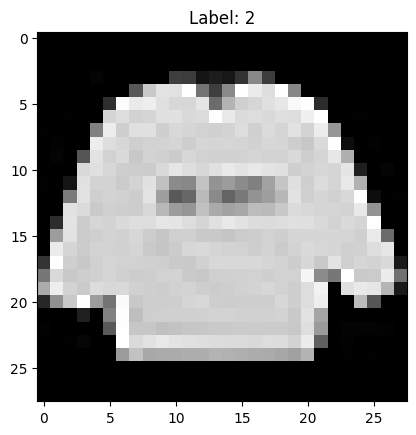

In [35]:
fmnist_train.fillna(0, inplace=True)
X = fmnist_train.drop(columns=["label", "Id"])
y = fmnist_train["label"]
X = X / 255.0

plt.imshow(X.iloc[0].values.reshape(28, 28), cmap='gray')
plt.title(f"Label: {y.iloc[0]}")
plt.show()

In [ ]:
X = fmnist_train.drop(columns=["label", "Id"]).values
y = fmnist_train["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [ ]:
model = Sequential([
    Input(shape=(784,)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train_cat, epochs=20, batch_size=128, verbose=1, validation_data=(X_val_scaled, y_val_cat))

nn_val_proba = model.predict(X_val_scaled)

Epoch 1/20
107/107 [==============================] - 2s 10ms/step - loss: 0.8031 - accuracy: 0.7223 - val_loss: 0.4703 - val_accuracy: 0.8333
Epoch 2/20
107/107 [==============================] - 1s 8ms/step - loss: 0.5253 - accuracy: 0.8117 - val_loss: 0.4531 - val_accuracy: 0.8369
Epoch 3/20
107/107 [==============================] - 1s 8ms/step - loss: 0.4554 - accuracy: 0.8346 - val_loss: 0.3989 - val_accuracy: 0.8530
Epoch 4/20
107/107 [==============================] - 1s 8ms/step - loss: 0.4162 - accuracy: 0.8495 - val_loss: 0.4093 - val_accuracy: 0.8495
Epoch 5/20
107/107 [==============================] - 1s 8ms/step - loss: 0.3864 - accuracy: 0.8547 - val_loss: 0.3890 - val_accuracy: 0.8592
Epoch 6/20
107/107 [==============================] - 1s 8ms/step - loss: 0.3597 - accuracy: 0.8672 - val_loss: 0.3785 - val_accuracy: 0.8609
Epoch 7/20
107/107 [==============================] - 1s 8ms/step - loss: 0.3431 - accuracy: 0.8730 - val_loss: 0.3807 - val_accuracy: 0.8680
Epoch

In [26]:
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_val_proba = cat_model.predict_proba(X_val)

In [27]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_val_proba = lgb_model.predict_proba(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160866
[LightGBM] [Info] Number of data points in the train set: 13632, number of used features: 782
[LightGBM] [Info] Start training from score -2.243619
[LightGBM] [Info] Start training from score -2.306407
[LightGBM] [Info] Start training from score -2.337823
[LightGBM] [Info] Start training from score -2.310835
[LightGBM] [Info] Start training from score -2.327993
[LightGBM] [Info] Start training from score -2.320497
[LightGBM] [Info] Start training from score -2.301998
[LightGBM] [Info] Start training from score -2.278809
[LightGBM] [Info] Start training from score -2.314540
[LightGBM] [Info] Start training from score -2.286720


In [31]:
ensemble_val_proba = (nn_val_proba + cat_val_proba + lgb_val_proba) / 3
ensemble_val_pred = np.argmax(ensemble_val_proba, axis=1)
val_accuracy = accuracy_score(y_val, ensemble_val_pred)
print(f"Accuracy ансамбля на валидации: {val_accuracy:.4f}")

Accuracy ансамбля на валидации: 0.8859


In [34]:
X_test = fmnist_test.drop(columns=["Id"]).values
X_test_scaled = scaler.transform(X_test)

nn_test_proba = model.predict(X_test_scaled)
cat_test_proba = cat_model.predict_proba(X_test)
lgb_test_proba = lgb_model.predict_proba(X_test)

ensemble_test_proba = (nn_test_proba + cat_test_proba + lgb_test_proba) / 3
ensemble_test_pred = np.argmax(ensemble_test_proba, axis=1)

sample_submission["label"] = ensemble_test_pred
sample_submission.to_csv("submission.csv", index=False)

313/313 [==============================] - 1s 2ms/step
